In [64]:
pip install librosa soundfile numpy sklearn pyaudio

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-pypi-packag

In [65]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


In [66]:
def extract_feature(file_name, mfcc=True, chroma=True, mel=True):
    try:
        X, sample_rate = librosa.load(file_name, sr=None, duration=3.0)  # load first 3 seconds
        result = np.array([])

        if chroma or mel:
            stft = np.abs(librosa.stft(X))

        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma_feat = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, chroma_feat))
        if mel:
            mel_feat = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
            result = np.hstack((result, mel_feat))

        return result
    except Exception as e:
        print(f"[ERROR] Could not process file {file_name}: {e}")
        return None


In [67]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

observed_emotions=['calm', 'happy', 'fearful', 'disgust']

In [68]:
def load_data(test_size=0.2):
    x,y=[],[]
    for file in glob.glob("C:\\Users\\HP-1\\OneDrive\\Desktop\\SIT\\New folder\\audio_speech_actors_01-24\\Actor_*\\*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [69]:
x_train,x_test,y_train,y_test=load_data(test_size=0.25)

In [70]:
print((x_train.shape[0], x_test.shape[0]))

(512, 171)


In [71]:
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 180


In [72]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)


MPC Classifier

In [73]:
model = MLPClassifier(
    hidden_layer_sizes=(512, 256, 128),  # deeper model
    activation='relu',
    solver='adam',
    batch_size=64,
    learning_rate='adaptive',
    max_iter=1000,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42
)


In [74]:
model.fit(x_train,y_train)

,hidden_layer_sizes,"(512, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,64
,learning_rate,'adaptive'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,1000
,shuffle,True
,random_state,42


In [75]:
y_pred=model.predict(x_test)

In [76]:
y_pred = model.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy: 0.5730994152046783

Classification Report:
               precision    recall  f1-score   support

        calm       0.54      0.79      0.65        39
     disgust       0.58      0.61      0.60        51
     fearful       0.58      0.68      0.63        41
       happy       0.62      0.20      0.30        40

    accuracy                           0.57       171
   macro avg       0.58      0.57      0.54       171
weighted avg       0.58      0.57      0.55       171



Random Forest Classifier

In [77]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)


In [78]:
rf.fit(x_train,y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [79]:
y_pred = model.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy: 0.5730994152046783

Classification Report:
               precision    recall  f1-score   support

        calm       0.54      0.79      0.65        39
     disgust       0.58      0.61      0.60        51
     fearful       0.58      0.68      0.63        41
       happy       0.62      0.20      0.30        40

    accuracy                           0.57       171
   macro avg       0.58      0.57      0.54       171
weighted avg       0.58      0.57      0.55       171



Logistic Regression

In [80]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(x_train, y_train)

c:\Users\HP-1\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\HP-1\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'multinomial'


In [81]:
y_pred = model.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy: 0.695906432748538

Classification Report:
               precision    recall  f1-score   support

        calm       0.77      0.85      0.80        39
     disgust       0.81      0.67      0.73        51
     fearful       0.64      0.73      0.68        41
       happy       0.56      0.55      0.56        40

    accuracy                           0.70       171
   macro avg       0.69      0.70      0.69       171
weighted avg       0.70      0.70      0.70       171



XGB Classifier

In [82]:
from xgboost import XGBClassifier
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(x_train, y_train)


c:\Users\HP-1\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:06:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [83]:
y_pred = model.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy: 0.7134502923976608

Classification Report:
               precision    recall  f1-score   support

        calm       0.86      0.95      0.90        39
     disgust       0.76      0.63      0.69        51
     fearful       0.64      0.85      0.73        41
       happy       0.58      0.45      0.51        40

    accuracy                           0.71       171
   macro avg       0.71      0.72      0.71       171
weighted avg       0.71      0.71      0.70       171



kNN

In [84]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5)
model.fit(x_train, y_train)


,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [85]:
y_pred = model.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy: 0.6140350877192983

Classification Report:
               precision    recall  f1-score   support

        calm       0.76      0.97      0.85        39
     disgust       0.56      0.45      0.50        51
     fearful       0.51      0.63      0.57        41
       happy       0.62      0.45      0.52        40

    accuracy                           0.61       171
   macro avg       0.61      0.63      0.61       171
weighted avg       0.61      0.61      0.60       171



SVM (Higgest Accuracy)

In [86]:
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler


In [87]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


In [88]:
model = SVC(kernel='rbf', C=10, gamma='scale') 
model.fit(x_train, y_train)


,C,10
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


Accuracy: 0.7894736842105263

Classification Report:
               precision    recall  f1-score   support

        calm       0.86      0.97      0.92        39
     disgust       0.92      0.67      0.77        51
     fearful       0.66      0.90      0.76        41
       happy       0.76      0.65      0.70        40

    accuracy                           0.79       171
   macro avg       0.80      0.80      0.79       171
weighted avg       0.81      0.79      0.79       171



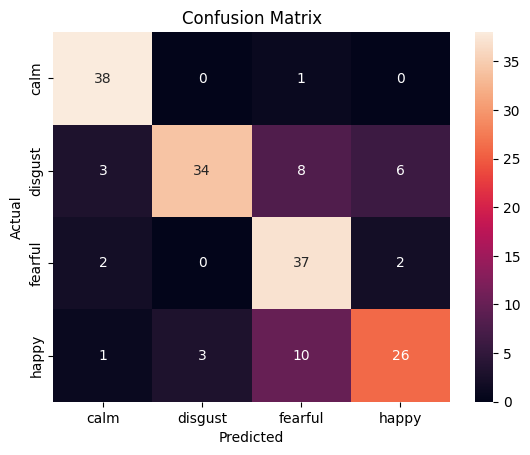

In [89]:
y_pred = model.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
